# Deep Learning


In [2]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
%matplotlib notebook
%matplotlib inline

## Task 1 - Neural Network

Recommended Watch: https://www.youtube.com/playlist?list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi

This playlist will help build a really solid intuitive understanding of how (and why) neural networks work.

#### Instructions:
In this task, you will be implementing a neural network from scratch using numpy. The skeleton of the neural network class is provided to you. You only need to write the parts that are incomplete/empty.

*Forward/backward pass & Weight Update:* Implement the forward and backward pass algorithms. Try to vectorize your code as much as possible, relying on numpy functions instead of for loops.

*Optimizers:*
Full-batch Gradient Descent has been implemented for you. You need to implement minibatch and stochastic gradient descent variants.

For weights we will use standard normal distribution (0 mean and 1 var).
Biases will be initialized to all zero.

**Visualization code** is provided to plot the learnt decision boundary of your model.


*Activation Functions:* You will implement the following activation functions (note that forward and backward pass will need to be adjusted according to the choice of the activation function):
- Sigmoid
- ReLU
- Leaky ReLU (leaky slope is fixed at 0.05)


In [ ]:
def plot_decision_boundary(pred_func, x_min, x_max, y_min, y_max, cmap, ax):
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.flatten(), yy.flatten()])
    Z = Z.reshape(xx.shape)
    # Plot the contour
    ax.contourf(xx, yy, Z, cmap=cmap, alpha=0.5)

In [ ]:
class NeuralNetwork():
    @staticmethod
    def cross_entropy_loss(y_pred, y_true):
        e = 1e-10
        y_pred = np.clip(y_pred, e, 1 - e)
        m = y_pred.shape[0]
        ce_loss = -1/m * (np.sum(y_true * np.log(y_pred)))
        return ce_loss
    
    @staticmethod
    def mean_squared_loss(y_pred, y_true):
        ms_loss = np.square(np.mean((y_pred-y_true)))
        return ms_loss
    
    @staticmethod
    def accuracy(y_pred, y_true):
        acc = np.mean(y_pred ==  y_true)
        return acc
    
    @staticmethod
    def softmax(x):
        normalized_x = x - np.max(x, axis =1, keepdims = True)
        exp = np.exp(normalized_x)
        SM = exp/np.sum(exp, axis = 1, keepdims=True)
        return SM
    
    @staticmethod
    def sigmoid(x):
        return 1/(1+np.exp(-x))

    @staticmethod
    def ReLU(x):
        return np.maximum(0,x)

    def Leaky_ReLU(self, x):
        return np.where(x > 0, x, self.leaky_slope * x)

    def __init__(self, nodes_per_layer: list[int], mode: str = 'classification', optimizer: str = 'fullbatch', activation: str = 'sigmoid', batch_size: int = 64):
        '''Creates a Feed-Forward Neural Network.
        "nodes_per_layer" is a list containing the number of nodes in each layer (including the input layer) e.g. [2, 10, 10, 2] (2 features, 2 hidden layers with 10 neurons each, 2 classes)"
        '''

        if len(nodes_per_layer) < 2:
            raise ValueError('Network must have at least 2 layers (input and output).')
        if not (np.array(nodes_per_layer) > 0).all():
            raise ValueError('The number of nodes in all layers must be positive.')
        
        assert mode.lower() in ['classification', 'regression'], "Only classification and regression modes are supported"
        assert optimizer.lower() in ['sgd', 'minibatch', 'fullbatch'], 'Unknown Optimizer'
        assert activation.lower() in ['sigmoid', 'relu', 'leaky_relu'], 'Unknown activation function'
        
        self.num_layers = None
        self.mode = mode
        self.nodes_per_layer = nodes_per_layer
        self.input_shape = None
        self.output_shape = None
        self.optimizer = optimizer
        self.activation_strat = activation
        self.batch_size = batch_size
        
        if activation == 'leaky_relu':
            self.leaky_slope = 0.05
        
        # Initialize all weights based on a standard normal distribution and all biases to 0.
        self.weights_ = []
        self.biases_ = []
        self.__init_weights(nodes_per_layer)
    
    
    def __init_weights(self, nodes_per_layer):
        '''Initializes all weights based on a standard normal distribution and all biases to 0.'''
        np.random.seed(SEED)
        for i, _ in enumerate(nodes_per_layer):
            if i == 0:
                
                continue
            
            weight_matrix = np.random.normal(size=(nodes_per_layer[i-1], nodes_per_layer[i]))
            self.weights_.append(weight_matrix)
            bias_vector = np.zeros(shape=(nodes_per_layer[i],))
            self.biases_.append(bias_vector)
    

            
            
    def fit(self, Xs, Ys, X_val, Y_val, epochs, lr=1e-3):
        '''Trains the model on the given dataset for "epoch" number of itterations with step size="lr". 
        Returns list containing loss for each epoch.'''
        self.history = []
        self.val_history = []
        self._run_optimizer(Xs,Ys, X_val, Y_val, epochs, lr)
        return self.history, self.val_history


    def _run_optimizer(self, Xs, Ys, X_val, Y_val, epochs, lr):
        ''' Executes the gradient descent algorithm '''
        
        if self.optimizer == 'fullbatch':
            for epoch in tqdm(range(epochs)):    
                activations = self.forward_pass(Xs) # Forward Pass over whole dataset
                deltas = self.backward_pass(Ys, activations) # Backward pass takes layer activations and true labels as input
                
                layer_inputs = [Xs] + activations[:-1]
                self.weight_update(deltas, layer_inputs, lr) # Weight update
                        
                preds = self.predict(Xs) # Make prediction on input sample
                current_loss = self.cross_entropy_loss(preds, Ys) if self.mode == 'classification' else self.mean_squared_loss(preds, Ys)
                self.history.append(current_loss)

                # Compute Validation Loss at the end of each epoch
                preds = self.predict(X_val)
                current_loss = self.cross_entropy_loss(preds, Y_val) if self.mode == 'classification' else self.mean_squared_loss(preds, Y_val)
                self.val_history.append(current_loss)
                
        elif self.optimizer == 'sgd':
            for epoch in tqdm(range(epochs)):
                indices = np.arange(Xs.shape[0])
                np.random.shuffle(indices)
                
                # for a in range(indices):
                for a in indices:
                    x_sample = Xs[a:a + 1]
                    y_sample = Ys[a:a + 1]
                    activations = self.forward_pass(x_sample)
                    deltas = self.backward_pass(y_sample, activations)
                    layer_inputs = [x_sample] + activations[:-1]
                    self.weight_update(deltas, layer_inputs, lr)

                preds = self.predict(Xs)
                current_loss = self.cross_entropy_loss(preds, Ys) if self.mode == 'classification' else self.mean_squared_loss(preds, Ys)
                self.history.append(current_loss)

                preds = self.predict(X_val)
                current_loss = self.cross_entropy_loss(preds, Y_val) if self.mode == 'classification' else self.mean_squared_loss(preds, Y_val)
                self.val_history.append(current_loss)

            "Code here"
            
        elif self.optimizer == 'minibatch':
            for epoch in tqdm(range(epochs)):
                indices = np.arange(Xs.shape[0])
                np.random.shuffle(indices)

                for first_idx in range(0, Xs.shape[0], self.batch_size):
                    last_idx = min(first_idx + self.batch_size, Xs.shape[0])
                    batch_idxs = indices[first_idx:last_idx]
                    x_batch = Xs[batch_idxs]
                    y_batch = Ys[batch_idxs]
                    activations = self.forward_pass(x_batch)
                    deltas = self.backward_pass(y_batch, activations)
                    layer_inputs = [x_batch] + activations[:-1]
                    self.weight_update(deltas, layer_inputs, lr)

                preds = self.predict(Xs)
                current_loss = self.cross_entropy_loss(preds, Ys) if self.mode == 'classification' else self.mean_squared_loss(preds, Ys)
                self.history.append(current_loss)

                preds = self.predict(X_val)
                current_loss = self.cross_entropy_loss(preds, Y_val) if self.mode == 'classification' else self.mean_squared_loss(preds, Y_val)
                self.val_history.append(current_loss)
            
            "Code here"
            
    def forward_pass(self, input_data):
        '''Executes the feed forward algorithm.
        "input_data" is the input to the network in row-major form
        Returns "activations", which is a list of all layer outputs (excluding input layer of course)'''
        
        activations = []
        A = input_data
        for a in range(len(self.weights_)):
            Z = np.dot(A, self.weights_[a]) + self.biases_[a]
            if a == len(self.weights_) - 1:
                if self.mode == 'classification':
                    A = self.softmax(Z)
                else:
                    A = Z
            else:
                if self.activation_strat == 'sigmoid':
                    A = self.sigmoid(Z)
                elif self.activation_strat == 'relu':
                    A = self.ReLU(Z)
                elif self.activation_strat == 'leaky_relu':
                    A = self.Leaky_ReLU(Z)
            activations.append(A)
    
        return activations
    
    def backward_pass(self, targets, layer_activations):
        '''Executes the backpropagation algorithm.
        "targets" is the ground truth/labels.
        "layer_activations" are the return value of the forward pass step.
        Returns "deltas", which is a list containing weight update values for all layers (excluding the input layer of course).'''
        
        deltas = [None] * len(self.weights_)
        if self.mode == 'classification':

            delta = layer_activations[-1] - targets
        else:

            delta = (layer_activations[-1] - targets)
        deltas[-1] = delta

        for l in reversed(range(len(deltas) -1)):
            a = layer_activations[l]
            if self.activation_strat == 'sigmoid':
                derivative = a * (1 - a)
            elif self.activation_strat == 'relu':
                derivative = np.where(a > 0, 1, 0)
            elif self.activation_strat == 'leaky_relu':
                derivative = np.where(a > 0, 1, self.leaky_slope)

            delta = np.dot(deltas[l + 1], self.weights_[l + 1].T) * derivative
            deltas[l] = delta

        return deltas

    def weight_update(self, deltas, layer_inputs, lr):
        '''Executes the gradient descent algorithm.
        "deltas" is return value of the backward pass step
        "layer_inputs" is a list containing the inputs for all layers (including the input layer)
        "lr" is the learning rate'''
        for a in range(len(self.weights_)):
            gradient_w = np.dot(layer_inputs[a].T, deltas[a])/layer_inputs[a].shape[0]
            gradient_b = np.mean(deltas[a], axis = 0)
            self.weights_[a] -= lr * gradient_w
            self.weights_[a] -= lr*gradient_b
   
        
    def predict(self, Xs):
        '''Returns the model predictions (output of the last layer) for the given "Xs".'''
        return self.forward_pass(Xs)[-1]
    
    def evaluate(self, Xs, Ys):
        '''Returns appropriate metrics for the task, calculated on the dataset passed to this method.'''
        pred = self.predict(Xs)
        if self.mode == 'regression':
            return self.mean_squared_loss(pred, Ys)
        elif self.mode == 'classification':
            return self.cross_entropy_loss(pred, Ys), self.accuracy(pred.argmax(axis=1), Ys.argmax(axis=1))    

Generating a moons dataset for binary classification:

[Text(0.5, 0, 'Feature 1'), Text(0, 0.5, 'Feature 2')]

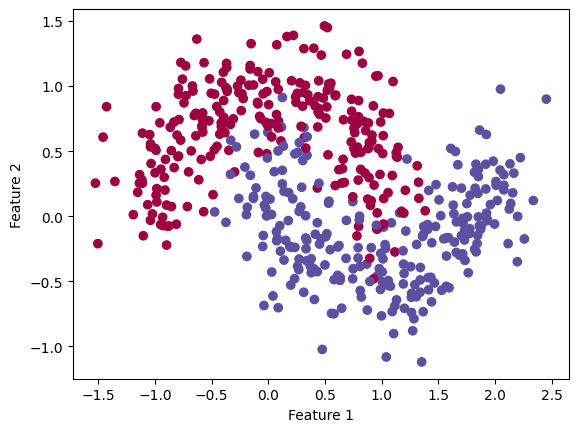

In [5]:
data_x, data_y = make_moons(500, noise=0.25, random_state=SEED)
plt.scatter(data_x[:,0], data_x[:,1], c=data_y, cmap=plt.cm.Spectral)
plt.gca().set(xlabel='Feature 1', ylabel='Feature 2')

Doing an 80-20 train-test split

In [6]:
X_train, X_val, Y_train, Y_val = train_test_split(data_x, data_y, test_size = 0.2, random_state=SEED)

### Classification task + Plotting the loss curves
- To check your implementation efficiency, we will check the running time of your code.<br>
- The secret to improving your efficency: __Vectorize__

### Your running time will be graded.

In [7]:
import time

def plot_losses(train_hist, val_hist):
    plt.figure(figsize=(12, 6))
    plt.plot(train_hist, label= 'traing Loss')
    plt.plot(val_hist, label = 'Validation Loss')
    plt.xlabel('EPOCH')
    plt.ylabel('LOSS')
    plt.title('LOSS CURVE')
    plt.legend()
    plt.show()
    

  0%|          | 0/500 [00:00<?, ?it/s]

Runtime of the algorithm is  3.683  seconds


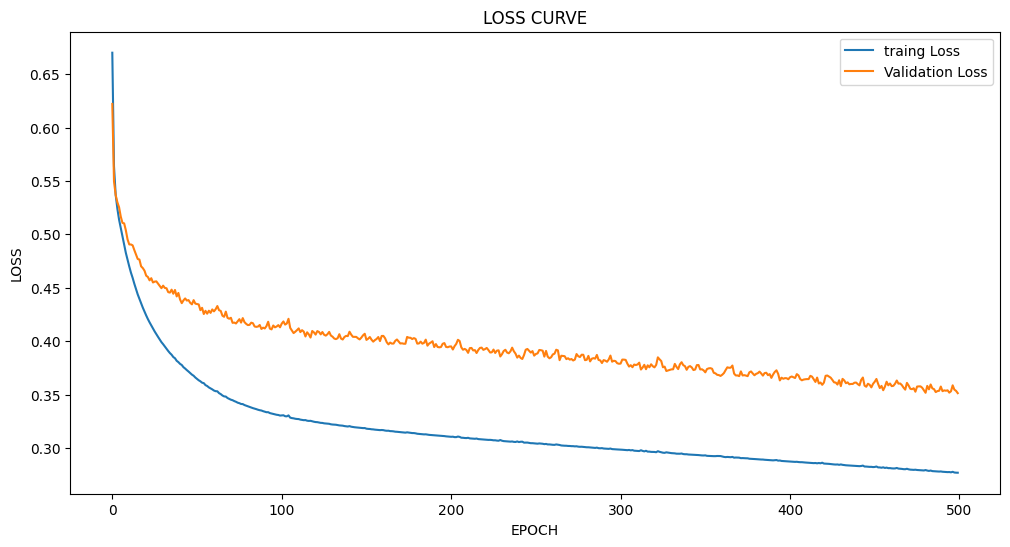

In [ ]:
ytrain_one_hot = pd.get_dummies(Y_train).values
yval_one_hot = pd.get_dummies(Y_val).values
nn = NeuralNetwork([2, 60, 40, 20, 2], mode='classification', activation='sigmoid', optimizer = 'minibatch', batch_size=64)
start = time.time()
history, val_hist = nn.fit(X_train, ytrain_one_hot, X_val, yval_one_hot, epochs = 500, lr = 0.01)


end = time.time()
print("Runtime of the algorithm is ",round((end - start),3)," seconds")

plot_losses(history, val_hist)

In [9]:
print(np.min(val_hist))

0.35129295967578517


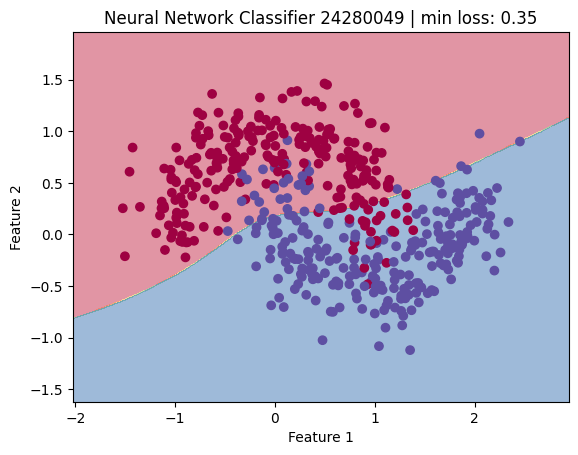

In [10]:
fig, ax = plt.subplots()
x_min, x_max = data_x[:, 0].min() - .5, data_x[:, 0].max() + .5
y_min, y_max = data_x[:, 1].min() - .5, data_x[:, 1].max() + .5
plot_decision_boundary(lambda x: nn.predict(x).argmax(axis=1), 
                       x_min, x_max, y_min, y_max, 
                       plt.cm.Spectral, ax)
ax.scatter(data_x[:,0], data_x[:,1], c=data_y, cmap=plt.cm.Spectral)
ax.set(xlabel='Feature 1', ylabel='Feature 2', title=f'Neural Network Classifier {rollnumber} | min loss: {np.min(val_hist):.2f}')
plt.show()

## Task 2 - Experimentation

Experiment with different network sizes, activation functions, learning rates, epochs, and optimizers, and comment on which weight activation function + optimizer yield the best results. Go crazy!

*Note*: Add at least 5 experiments with various nodes per layer and number of layers in the notebook, and calculate the total number of parameters for each of your models. Add those as a comment next to your `network_size` declaration

In [11]:
np.set_printoptions(precision=3)

# Experiment 1

  0%|          | 0/1000 [00:00<?, ?it/s]

runtime of the 1st experiment keeping the model parameter same with the actual model but the epoch which is set at 1000, is 5.417 seconds


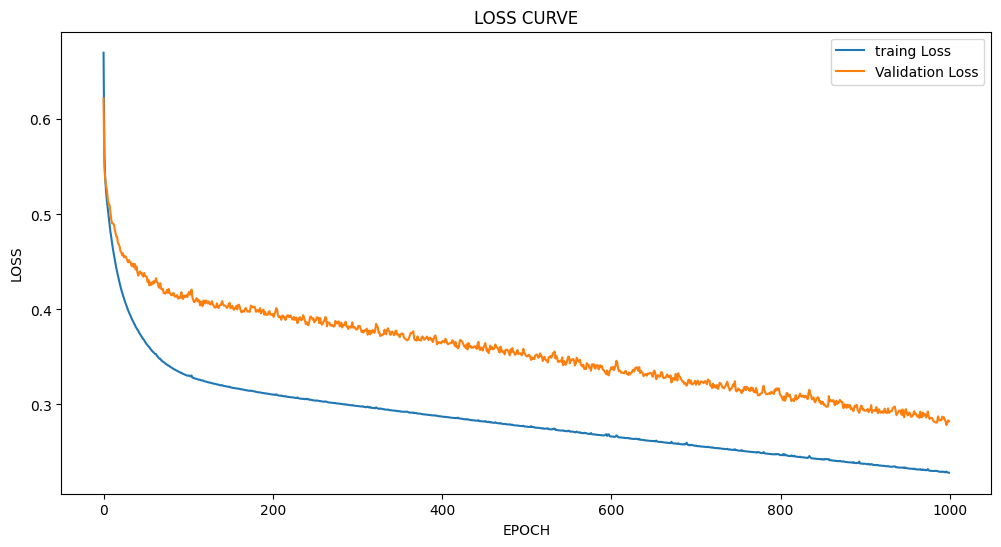

In [12]:
#experiment 1

nn = NeuralNetwork([2, 60, 40, 20, 2],mode = 'classification', activation = 'sigmoid', optimizer = 'minibatch', batch_size = 64)
start = time.time()
history, val_hist = nn.fit(X_train, pd.get_dummies(Y_train).values, X_val, pd.get_dummies(Y_val).values, epochs=1000, lr= 0.01)

end = time.time()
print('runtime of the 1st experiment keeping the model parameter same with the actual model but the epoch which is set at 1000, is', round((end-start), 3), 'seconds')
plot_losses(history, val_hist)


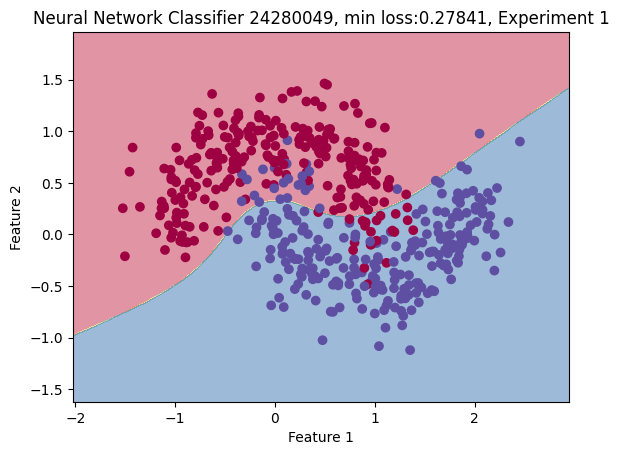

In [13]:
fig, ax = plt.subplots()
x_min, x_max = data_x[:, 0].min() - .5, data_x[:, 0].max() + .5
y_min, y_max = data_x[:, 1].min() - .5, data_x[:, 1].max() + .5
plot_decision_boundary(lambda x: nn.predict(x).argmax(axis=1), 
                       x_min, x_max, y_min, y_max, 
                       plt.cm.Spectral, ax)
ax.scatter(data_x[:,0], data_x[:,1], c=data_y, cmap=plt.cm.Spectral)
ax.set(xlabel='Feature 1', ylabel='Feature 2', title=f'Neural Network Classifier {rollnumber}, min loss:{round(np.min(val_hist), 5)}, Experiment 1')
plt.show()

Feel free to add more cells below this for further experimentation.

# Experiment 2

  0%|          | 0/500 [00:00<?, ?it/s]

runtime of the 2nd experiment with 2 hidden layers is 36.555 seconds


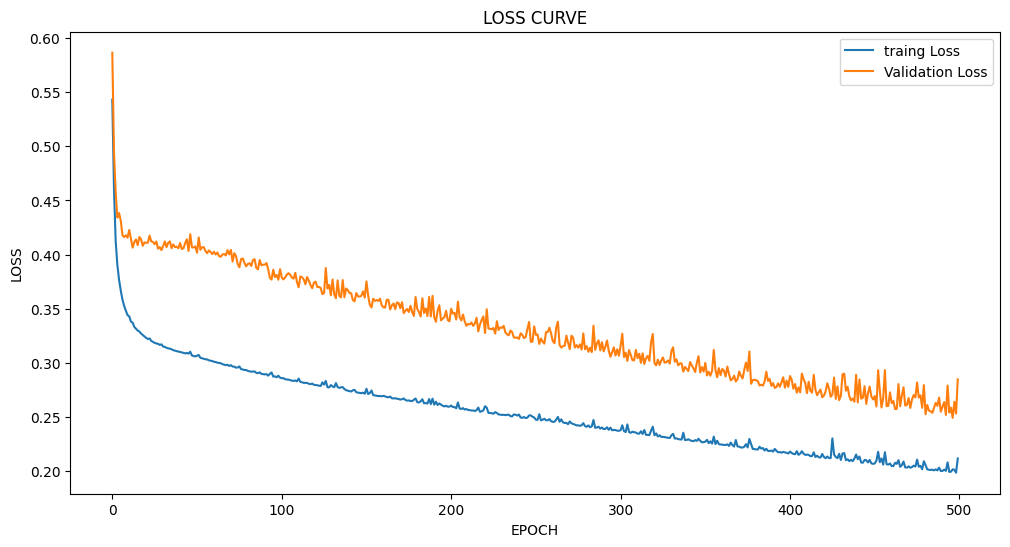

In [ ]:
#experiment 2
network_size_1 = [2, 100, 10, 2]
# mode_1 = 'classification'
# activation_1 = 'ReLU'
# optimizer_1 = 'sgd'
# batch_size_1 = 64

nn = NeuralNetwork(network_size_1,mode = 'classification', activation = 'sigmoid', optimizer = 'sgd', batch_size = 64)
start = time.time()
history, val_hist = nn.fit(X_train, pd.get_dummies(Y_train).values, X_val, pd.get_dummies(Y_val).values, epochs=500, lr= 0.001)

end = time.time()
print('runtime of the 2nd experiment with 2 hidden layers is',(end-start) 'seconds')
plot_losses(history, val_hist)


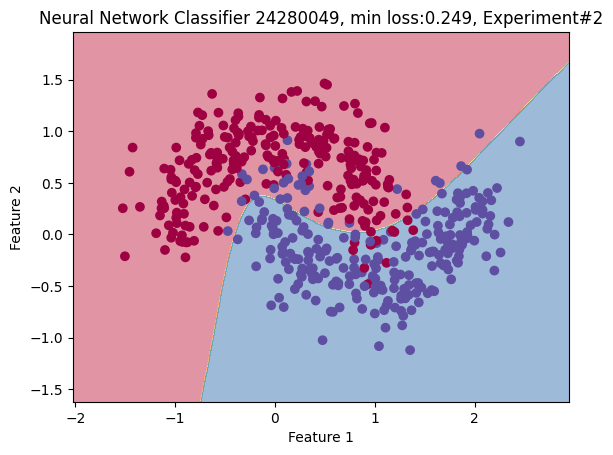

In [15]:
fig, ax = plt.subplots()
x_min, x_max = data_x[:, 0].min() - .5, data_x[:, 0].max() + .5
y_min, y_max = data_x[:, 1].min() - .5, data_x[:, 1].max() + .5
plot_decision_boundary(lambda x: nn.predict(x).argmax(axis=1), 
                       x_min, x_max, y_min, y_max, 
                       plt.cm.Spectral, ax)
ax.scatter(data_x[:,0], data_x[:,1], c=data_y, cmap=plt.cm.Spectral)
ax.set(xlabel='Feature 1', ylabel='Feature 2', title=f'Neural Network Classifier {rollnumber}, min loss:{round(np.min(val_hist), 3)}, Experiment#2')
plt.show()

# Experiment 3

  0%|          | 0/300 [00:00<?, ?it/s]

runtime of the 3rd experiment with 4 hidden layers and using sigmoid as an activation, and minibatch optimizer, and keeping epochs 300 is 1.835 seconds


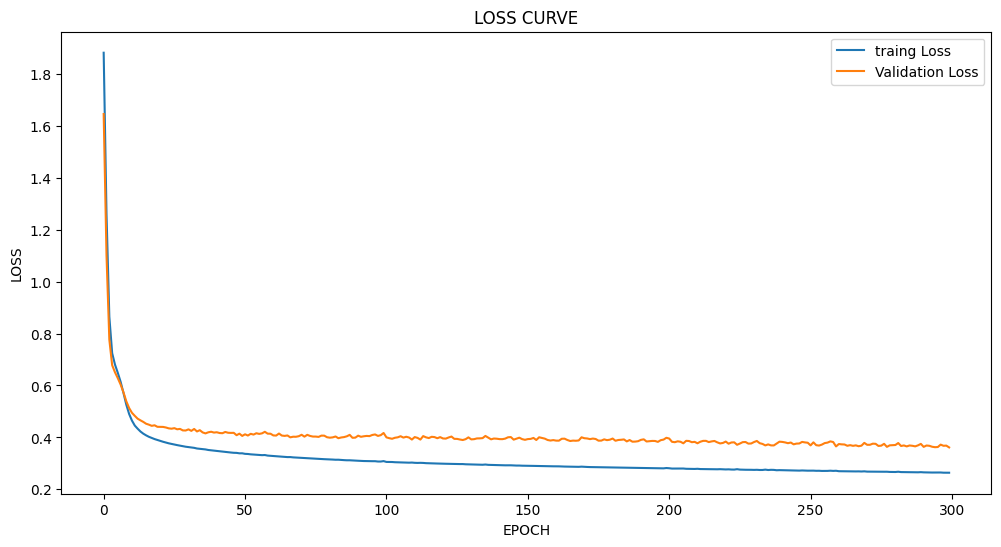

In [ ]:
#experiment 3
network_size_3 = [2, 50,60, 20, 10, 2]


nn = NeuralNetwork(network_size_3, mode = 'classification', activation ='sigmoid', optimizer = 'minibatch', batch_size = 64)
start = time.time()
history, val_hist = nn.fit(X_train, pd.get_dummies(Y_train).values, X_val, pd.get_dummies(Y_val).values, epochs=300, lr= 0.01)

end = time.time()
print('runtime of the 3rd experiment with 4 hidden layers and using sigmoid as an activation, and minibatch optimizer, and keeping epochs 300 is',(end-start), 'seconds')
plot_losses(history, val_hist)


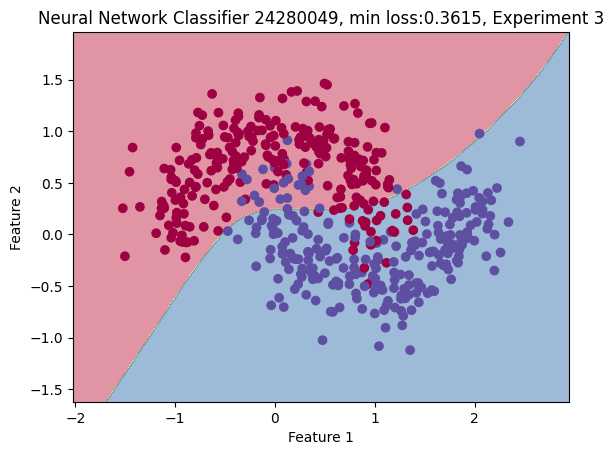

In [17]:
fig, ax = plt.subplots()
x_min, x_max = data_x[:, 0].min() - .5, data_x[:, 0].max() + .5
y_min, y_max = data_x[:, 1].min() - .5, data_x[:, 1].max() + .5
plot_decision_boundary(lambda x: nn.predict(x).argmax(axis=1), 
                       x_min, x_max, y_min, y_max, 
                       plt.cm.Spectral, ax)
ax.scatter(data_x[:,0], data_x[:,1], c=data_y, cmap=plt.cm.Spectral)
ax.set(xlabel='Feature 1', ylabel='Feature 2', title=f'Neural Network Classifier {rollnumber}, min loss:{round(np.min(val_hist), 4)}, Experiment 3')
plt.show()

# Experiment 4

  0%|          | 0/250 [00:00<?, ?it/s]

runtime of the 4th experiment with 3 hidden layers is, ReLU as an activation and minibatch for optimizer function 35.499 seconds


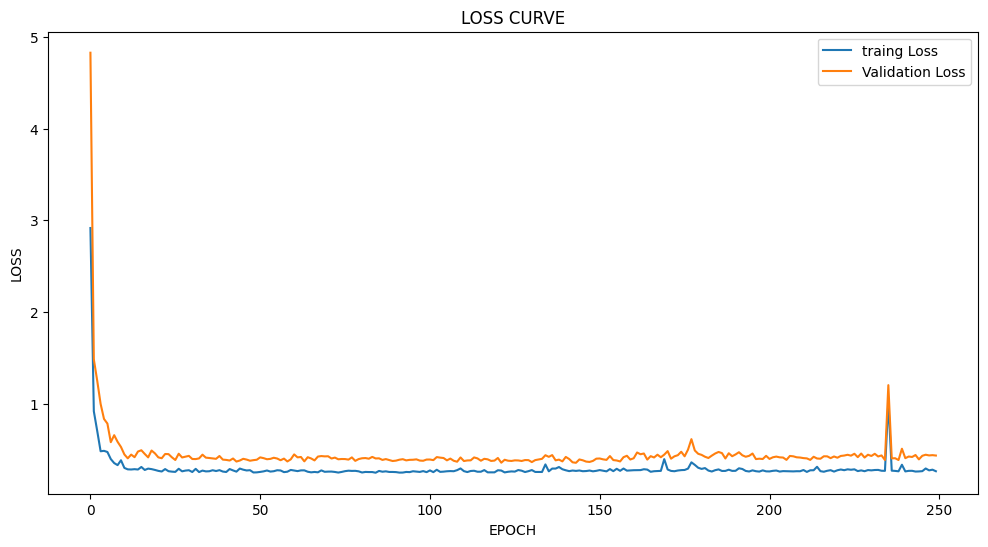

In [ ]:
#experiment 4
network_size_1 = [2, 200, 100, 45, 2]
# mode_1 = 'classification'
# activation_1 = 'ReLU'
# optimizer_1 = 'sgd'
# batch_size_1 = 64

nn = NeuralNetwork(network_size_1,mode = 'classification', activation = 'relu', optimizer = 'sgd', batch_size = 64)
start = time.time()
history, val_hist = nn.fit(X_train, pd.get_dummies(Y_train).values, X_val, pd.get_dummies(Y_val).values, epochs=250, lr= 0.001)

end = time.time()
print('runtime of the 4th experiment with 3 hidden layers is, ReLU as an activation and minibatch for optimizer function', (end-start), 'seconds')
plot_losses(history, val_hist)


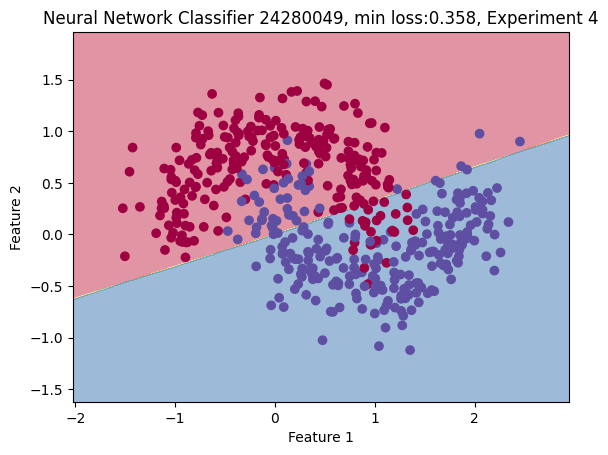

In [19]:
fig, ax = plt.subplots()
x_min, x_max = data_x[:, 0].min() - .5, data_x[:, 0].max() + .5
y_min, y_max = data_x[:, 1].min() - .5, data_x[:, 1].max() + .5
plot_decision_boundary(lambda x: nn.predict(x).argmax(axis=1), 
                       x_min, x_max, y_min, y_max, 
                       plt.cm.Spectral, ax)
ax.scatter(data_x[:,0], data_x[:,1], c=data_y, cmap=plt.cm.Spectral)
ax.set(xlabel='Feature 1', ylabel='Feature 2', title=f'Neural Network Classifier {rollnumber}, min loss:{round(np.min(val_hist), 5)}, Experiment 4')
plt.show()

# Experiment 5

  0%|          | 0/800 [00:00<?, ?it/s]

runtime of the 5th experiment with 5 hidden layers is 8.466 seconds


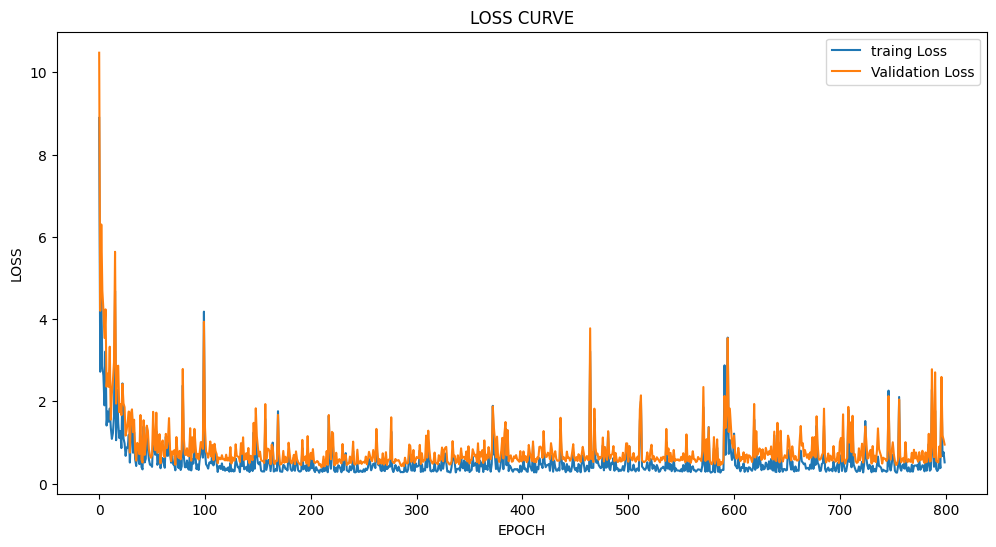

In [ ]:
network_size = [50, 512, 256, 128, 2]


nn = NeuralNetwork(network_size_1,mode = 'classification', activation = 'leaky_relu', optimizer = 'minibatch', batch_size = 64)
start = time.time()
history, val_hist = nn.fit(X_train, pd.get_dummies(Y_train).values, X_val, pd.get_dummies(Y_val).values, epochs=800, lr= 0.01)

end = time.time()
print('runtime of the 5th experiment with 5 hidden layers is',(end-start), 'seconds')
plot_losses(history, val_hist)


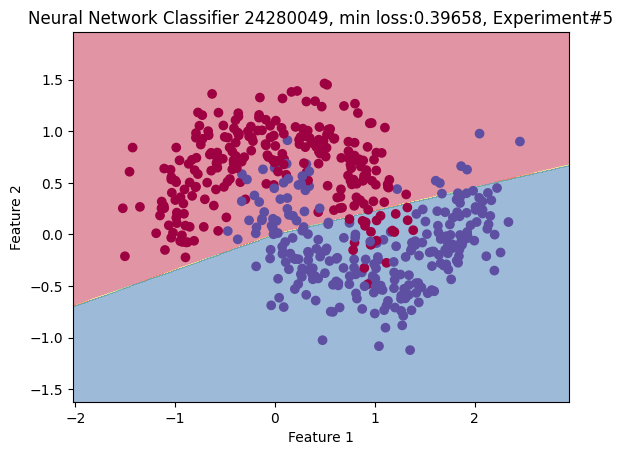

In [21]:
fig, ax = plt.subplots()
x_min, x_max = data_x[:, 0].min() - .5, data_x[:, 0].max() + .5
y_min, y_max = data_x[:, 1].min() - .5, data_x[:, 1].max() + .5
plot_decision_boundary(lambda x: nn.predict(x).argmax(axis=1), 
                       x_min, x_max, y_min, y_max, 
                       plt.cm.Spectral, ax)
ax.scatter(data_x[:,0], data_x[:,1], c=data_y, cmap=plt.cm.Spectral)
ax.set(xlabel='Feature 1', ylabel='Feature 2', title=f'Neural Network Classifier {rollnumber}, min loss:{round(np.min(val_hist), 5)}, Experiment#5')
plt.show()

# Task 3: Regression

Let's use the model we just created for a regression task. To make things interesting, we'll sample from a rather ugly regression equation:

$y = 2 X_1^5 + 4 X_2^2 - X_1 X_2 + 10 X_2 \cdot (\sin(X_1)^{13.5}) + 3 X_2 + 5 + \epsilon$

where $\epsilon$ represents the noise added to the data


In [22]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(8)

# Generate random data with two features (X1, X2)
num_samples = 500
X1 = 2 * np.random.rand(num_samples, 1)
X2 = 3 * np.random.rand(num_samples, 1)
noise = 2 * np.random.randn(num_samples, 1)

X = np.hstack((X1, X2))
# print(X)
# Regression equation
y = 2 * X1**5 + 4 * X2**2 - X1*X2 + 10*X2*(np.sin(X1)**13.5) + 3 * X2 + 5 + noise


Let's visualize this data:

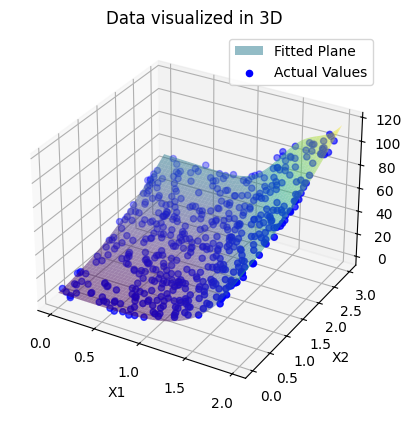

In [23]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

X1_grid, X2_grid = np.meshgrid(np.linspace(min(X1), max(X1), 100), np.linspace(min(X2), max(X2), 100))
y_pred_plane = 2 * X1_grid**5 + 4 * X2_grid**2 - X1_grid*X2_grid + 10*X2_grid*(np.sin(X1_grid)**13.5) + 3*X2_grid + 5

ax.plot_surface(X1_grid, X2_grid, y_pred_plane, alpha=0.5, cmap='viridis', label='Fitted Plane')
ax.scatter(X1, X2, y, c='blue', marker='o', label='Actual Values')

ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('y')
ax.set_title('Data visualized in 3D')

plt.legend()
plt.show()

Looks pretty complicated! Let's see if our neural network can learn to predict the y values given the features (Xs). 
First, split `X` and `y` into training and validation cohorts. 

In [24]:
X_train, X_val, Y_train, Y_val = train_test_split(X, y, test_size= 0.2, random_state=SEED)

In [25]:
print(f'X training dataset: {X_train[:5]}')
print(f'X validation dataset: {X_val[:5]}')
print(f'Y training dataset: {Y_train[:5]}')
print(f'Y validation dataset: {Y_val[:5]}')

X training dataset: [[0.996 2.969]
 [1.734 0.462]
 [1.125 2.719]
 [1.553 2.541]
 [0.911 0.782]]
X validation dataset: [[0.844 2.737]
 [1.462 2.345]
 [0.506 1.708]
 [0.106 2.165]
 [1.271 2.266]]
Y training dataset: [[48.44 ]
 [43.846]
 [50.556]
 [79.284]
 [14.567]]
Y validation dataset: [[42.189]
 [63.662]
 [22.45 ]
 [28.185]
 [47.132]]


Next, initialize your Neural Network class in regression mode. Experiment with different sizes and various combinations of optimizers and activation functions (remember to use a very small learning rate with ReLU) until you get the best results.

Note: You are required to show at least three of the models' results that you get.

## Experiment 1

  0%|          | 0/200 [00:00<?, ?it/s]

run time for the regression 1st experiment with relu activation and minibatch as an optimizer 0.796710729598999 seconds


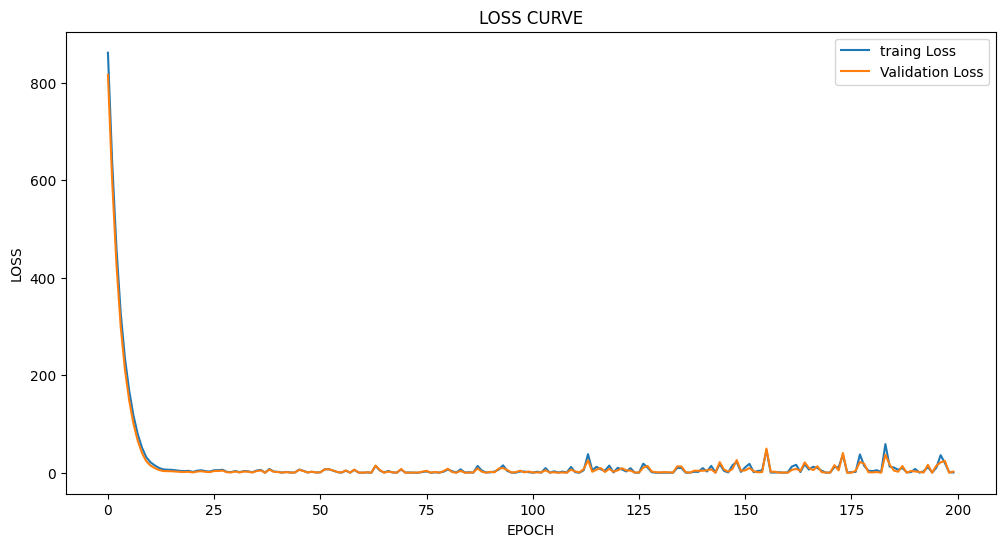

In [26]:
#Experiment 1
# ytrain_onehot = 
# yval_onehot = pd.get_dummies(Y_val).values
network_size = [2, 20, 10, 1]
nn = NeuralNetwork(network_size, mode='regression', activation = 'sigmoid', optimizer='minibatch', batch_size=32)
start = time.time()
# fit and plot the loss curves:
history, val_hist = nn.fit(X_train, Y_train, X_val, Y_val, epochs = 200, lr = .001)
end = time.time()

print(f'run time for the regression 1st experiment with relu activation and minibatch as an optimizer {(end-start)} seconds')
plot_losses(history, val_hist)

Let's see how well the model's predictions match to the ground truth values.

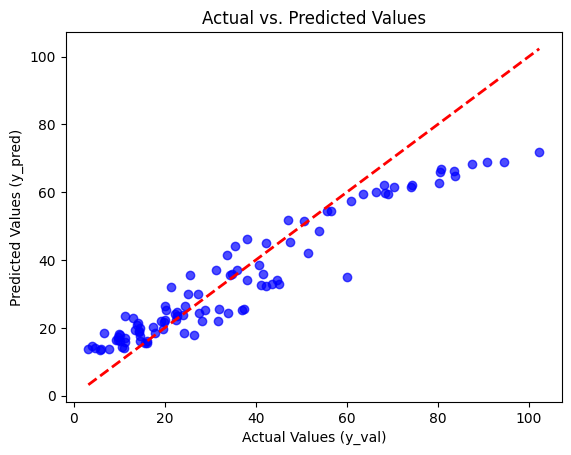

In [27]:
y_pred = nn.predict(X_val)

plt.scatter(Y_val, y_pred, c='blue', alpha=0.7)
plt.plot([min(Y_val), max(Y_val)], [min(Y_val), max(Y_val)], '--', color='red', linewidth=2)  # Diagonal line for reference
plt.xlabel('Actual Values (y_val)')
plt.ylabel('Predicted Values (y_pred)')
plt.title('Actual vs. Predicted Values')
plt.show()

In [28]:
r2 = r2_score(Y_val, y_pred)
print(f'R_Squared value for the 1st model :{round(r2, 3)}')

R_Squared value for the 1st model :0.856


Repeat this process with various sizes and hyperparameters.

## Experiment 2 

  0%|          | 0/100 [00:00<?, ?it/s]

run time for the regression 2nd experiment with sigmoid activation and sgd as an optimizer 0.796710729598999 seconds


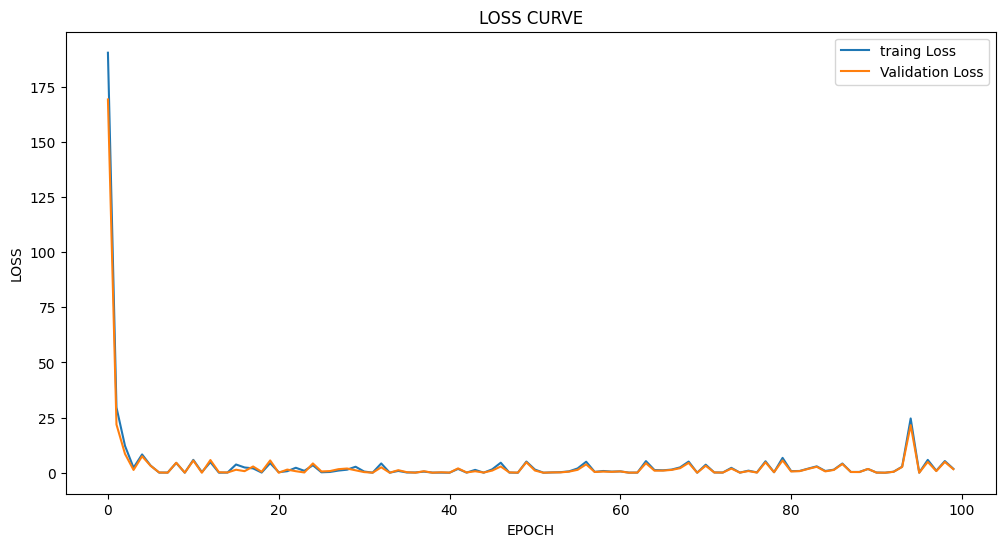

In [29]:
network_size = [2, 28, 24, 14, 1]

nn = NeuralNetwork(network_size, mode='regression', activation='sigmoid', optimizer='sgd', batch_size=64)

history, val_hist = nn.fit(X_train, Y_train, X_val, Y_val, epochs=100, lr=0.0001)


print(f'run time for the regression 2nd experiment with sigmoid activation and sgd as an optimizer {(end-start)} seconds')
plot_losses(history, val_hist)


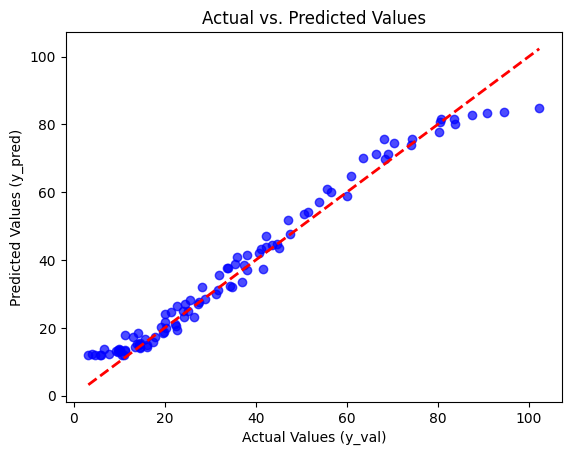

In [30]:
y_pred = nn.predict(X_val)

plt.scatter(Y_val, y_pred, c='blue', alpha=0.7)
plt.plot([min(Y_val), max(Y_val)], [min(Y_val), max(Y_val)], '--', color='red', linewidth=2)  # Diagonal line for reference
plt.xlabel('Actual Values (y_val)')
plt.ylabel('Predicted Values (y_pred)')
plt.title('Actual vs. Predicted Values')
plt.show()

In [31]:
r2 = r2_score(Y_val, y_pred)
print(f'R_Squared value for the 1st model :{round(r2, 3)}')

R_Squared value for the 1st model :0.973


## Experiment 3 

  0%|          | 0/100 [00:00<?, ?it/s]

run time for the regression 3rd experiment with sigmoid activation and sgd as an optimizer 8.571452140808105 seconds


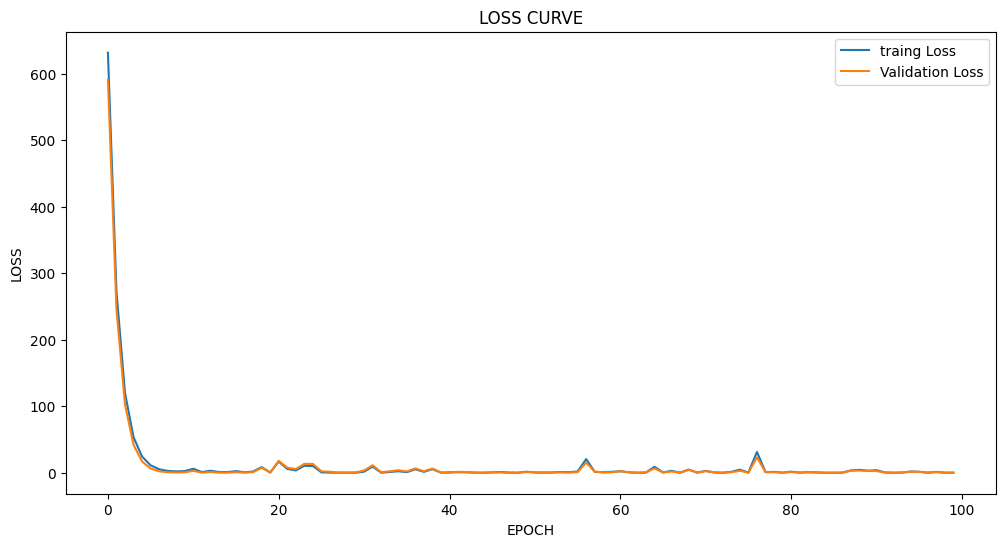

In [32]:
network_size = [2, 20, 15, 5, 1]

nn = NeuralNetwork(network_size, mode='regression', activation='sigmoid', optimizer='sgd', batch_size=128)
start = time.time()
history, val_hist = nn.fit(X_train, Y_train, X_val, Y_val, epochs=100, lr=0.0001)
end = time.time()

print(f'run time for the regression 3rd experiment with sigmoid activation and sgd as an optimizer {(end-start)} seconds')
plot_losses(history, val_hist)


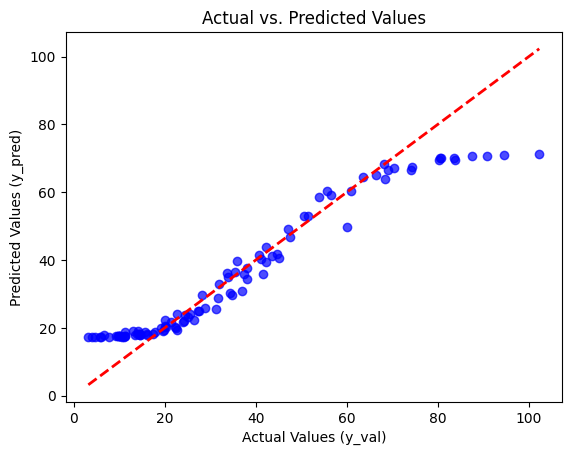

In [33]:
y_pred = nn.predict(X_val)

plt.scatter(Y_val, y_pred, c='blue', alpha=0.7)
plt.plot([min(Y_val), max(Y_val)], [min(Y_val), max(Y_val)], '--', color='red', linewidth=2)  # Diagonal line for reference
plt.xlabel('Actual Values (y_val)')
plt.ylabel('Predicted Values (y_pred)')
plt.title('Actual vs. Predicted Values')
plt.show()

In [34]:
r2 = r2_score(Y_val, y_pred)
print(f'R_Squared value for the 1st model :{round(r2, 3)}')

R_Squared value for the 1st model :0.91
